# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

*Generated with the assistance of AI. Please be cautious and review code, outputs, and interpretations before relying on results for research purposes.*

This notebook introduces and demonstrates how to explore [Dandiset 000617](https://dandiarchive.org/dandiset/000617/0.250311.1615), which contains two-photon calcium imaging and behavioral data from mice as part of a study on sequence learning and predictive coding. The data includes raw and processed neurophysiological recordings, ROI segmentations, behavioral measures (running, eye tracking), stimulus presentations, and rich metadata.

## Notebook Overview

This notebook will help you:
- Connect to the DANDI archive and list available NWB files in Dandiset 000617.
- Stream NWB files remotely and access two-photon imaging and associated processed data.
- Visualize:
  - Example two-photon imaging frames (with enhanced contrast)
  - ΔF/F (dff) traces for 10 sample cells
  - Segmentation masks for these ROIs, overlaid on an average image
  - The running speed trace (cm/s) of the mouse over the session
  - Timing of a specific movie stimulus (“movie_clip_A”)
  - Eye tracking (pupil area) over a portion of the session

Explanatory cells are included throughout to guide your exploration. All data loading and visualization in this notebook is performed by remotely streaming NWB files; no files are downloaded.

## Required Packages

- numpy
- matplotlib
- h5py
- remfile
- dandi
- pynwb

_All of these are assumed to be installed on your system._

## Accessing Dandiset 000617 and Listing NWB Files

Here we use the DANDI API to list the first ten NWB files available in the dandiset.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

dandiset_id = "000617"
dandiset_version = "0.250311.1615"

# Connect to the DANDI Archive and get the Dandiset object
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 10 NWB files available in this dandiset
assets = dandiset.get_assets_by_glob("*.nwb")
file_names = [asset.path for asset in islice(assets, 10)]
print("Sample NWB files in this dandiset:")
for name in file_names:
    print(name)

Sample NWB files in this dandiset:
sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294259213-acq-1294370664-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1293785946-acq-1293914856-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294259213-acq-1294370663-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1293785946-acq-1293914853-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1293785946-acq-1293914860-raw-movies_ophys.nwb


## Loading NWB Data Remotely

Below, we will work with one example NWB file from the dandiset:

`sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb`

Data will be loaded remotely via streaming (without downloading the entire file).

In [2]:
import h5py
import remfile
import pynwb

# Helper function to get the DANDI download URL for an asset
def get_download_url(asset_path, dandiset_id, dandiset_version):
    from dandi.dandiapi import DandiAPIClient
    client = DandiAPIClient()
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(asset_path))
    return asset.download_url

example_nwb_path = "sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb"
url = get_download_url(example_nwb_path, dandiset_id, dandiset_version)

# Open the remote NWB file using remfile and h5py
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file, "r")
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Visualize a Motion-Corrected Two-Photon Imaging Frame

We start by extracting and displaying a single frame (frame 0) from the motion-corrected two-photon imaging data. The contrast is enhanced for visualization.

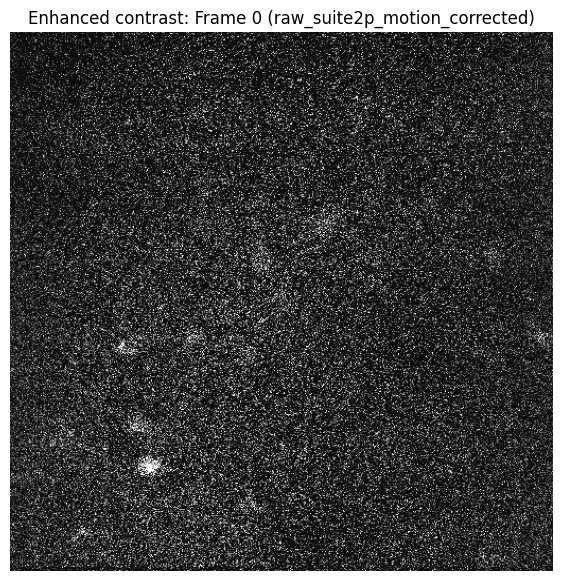

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Access the imaging data
tps = nwb.acquisition['raw_suite2p_motion_corrected']
frame = tps.data[0, :, :].astype(float)

# Enhance contrast for visualization
frame_min = np.percentile(frame, 1)
frame_max = np.percentile(frame, 99)
frame_disp = np.clip((frame - frame_min) / (frame_max - frame_min), 0, 1)

plt.figure(figsize=(7, 7))
plt.imshow(frame_disp, cmap='gray', aspect='auto')
plt.title('Enhanced contrast: Frame 0 (raw_suite2p_motion_corrected)')
plt.axis('off')
plt.show()

## Visualize ΔF/F Traces For Example Cells

Next, we plot ΔF/F traces (dff, normalized calcium activity) over time for a sample of 10 cells.

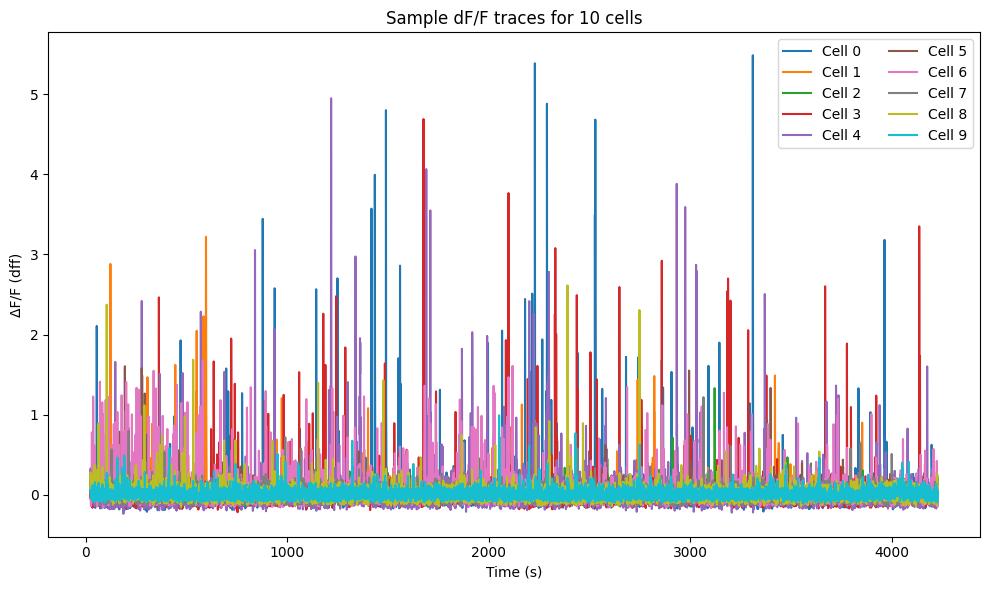

In [4]:
# Access DfOverF traces and timestamps
traces = nwb.processing['ophys'].data_interfaces['dff'].roi_response_series['traces'].data
if traces.shape[0] > 10000:
    downsample = 5
else:
    downsample = 1
traces_np = traces[::downsample, :]
time = nwb.processing['ophys'].data_interfaces['dff'].roi_response_series['traces'].timestamps[::downsample]
num_cells = traces_np.shape[1]
plot_cells = min(num_cells, 10)

plt.figure(figsize=(10, 6))
for i in range(plot_cells):
    plt.plot(time, traces_np[:, i], label=f'Cell {i}')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F (dff)')
plt.title('Sample dF/F traces for 10 cells')
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

## Visualize ROI Masks for These Cells

Here we overlay the segmentation masks (ROI outlines) for the same 10 cells on top of the average intensity image.

/tmp/ipykernel_82825/1660728356.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_rois)


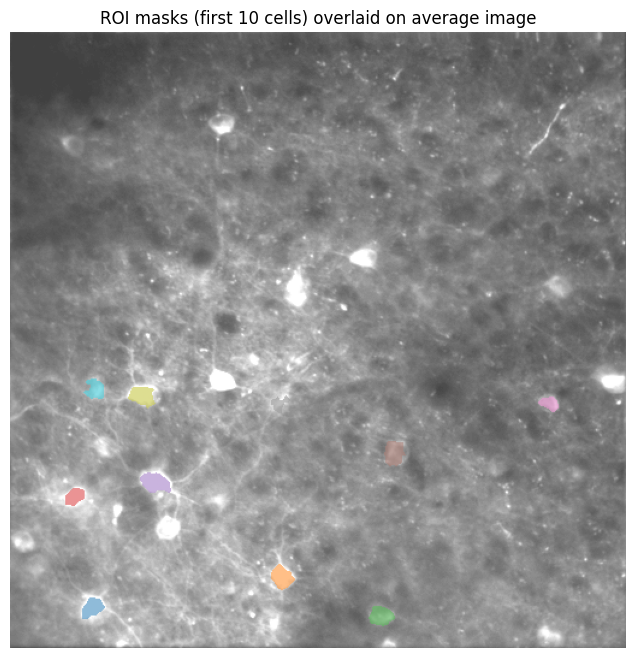

In [5]:
# Load average image for background
avg_img = nwb.processing['ophys'].data_interfaces['images'].images['average_image'].data[:]

# Get ROI info for the first 10 cells from the dff traces planeSegmentation
roi_table = nwb.processing['ophys'].data_interfaces['dff'].roi_response_series['traces'].rois.table
num_rois = min(10, len(roi_table.id))

img_shape = avg_img.shape
masks = roi_table['image_mask'][:num_rois]  # Each is (img_shape)

background = (avg_img - np.percentile(avg_img, 1)) / (np.percentile(avg_img, 99) - np.percentile(avg_img, 1))
background = np.clip(background, 0, 1)
color_overlay = np.stack([background] * 3, axis=2)

colors = plt.cm.get_cmap('tab10', num_rois)
for i, mask in enumerate(masks):
    color = colors(i)[:3]
    mask_2d = mask.astype(float)
    color_overlay[mask_2d > 0.2] = color  # Only highlight sufficiently strong pixels

plt.figure(figsize=(8, 8))
plt.imshow(background, cmap='gray', alpha=0.5)
plt.imshow(color_overlay, alpha=0.5)
plt.title('ROI masks (first 10 cells) overlaid on average image')
plt.axis('off')
plt.show()

## Visualize Running Speed Over the Session

Here we plot the running speed of the mouse (in cm/s) across the experiment.

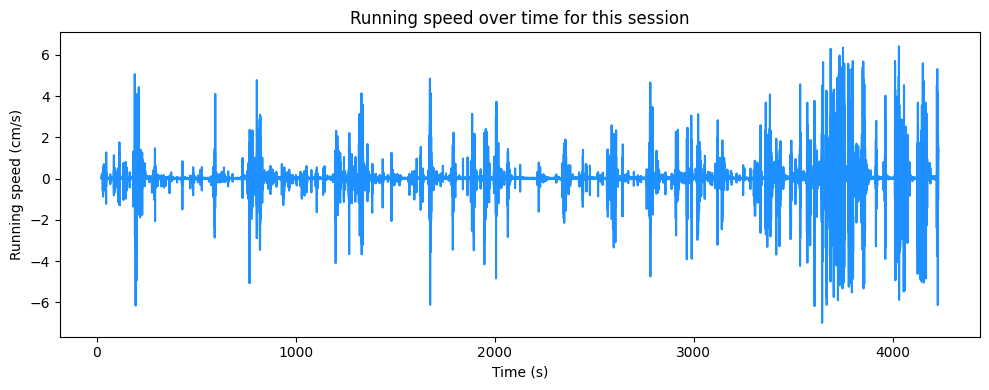

In [6]:
run_proc = nwb.processing.get('running', None)
if run_proc and 'speed' in run_proc.data_interfaces:
    speed_ts = run_proc.data_interfaces['speed']
    speed = speed_ts.data[:]
    t_speed = speed_ts.timestamps[:]
    speed_unit = speed_ts.unit
else:
    v_sig_ts = nwb.acquisition['v_sig']
    speed = v_sig_ts.data[:]
    t_speed = v_sig_ts.timestamps[:]
    speed_unit = v_sig_ts.unit

plt.figure(figsize=(10, 4))
plt.plot(t_speed, speed, color='dodgerblue')
plt.xlabel('Time (s)')
plt.ylabel(f'Running speed ({speed_unit})')
plt.title('Running speed over time for this session')
plt.tight_layout()
plt.show()

## Visualize Stimulus Presentation Intervals ("movie_clip_A")

We extract and plot when each presentation of "movie_clip_A" occurred throughout the session.

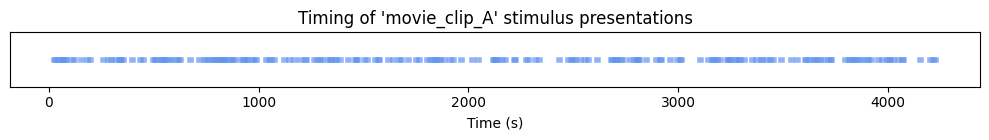

In [7]:
clip_A_int = nwb.intervals["movie_clip_A_presentations"]
start_A = clip_A_int.start_time[:]
stop_A = clip_A_int.stop_time[:]
num_A = len(start_A)

plt.figure(figsize=(10,1.5))
for i in range(num_A):
    plt.plot([start_A[i], stop_A[i]], [1, 1], lw=4, color='cornflowerblue', alpha=0.7)
plt.ylim(0.9, 1.1)
plt.yticks([])
plt.xlabel("Time (s)")
plt.title("Timing of 'movie_clip_A' stimulus presentations")
plt.tight_layout()
plt.show()

## Visualize Eye Tracking Data (Pupil Area)

This final section demonstrates how to extract and plot the pupil area from the eye tracking data, which is another prominent behavioral measure available in the file.

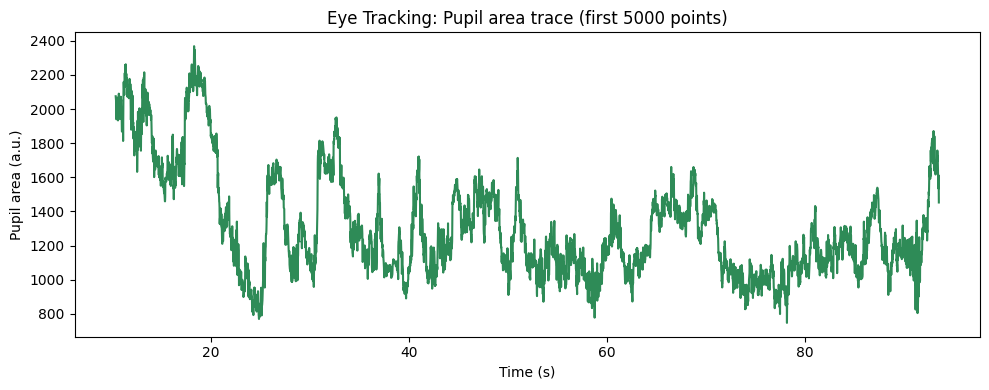

In [8]:
eyetrack = nwb.acquisition['EyeTracking']
pupil_area = eyetrack.spatial_series['pupil_tracking'].area[:]
pupil_time = eyetrack.spatial_series['pupil_tracking'].timestamps[:]

plt.figure(figsize=(10, 4))
plt.plot(pupil_time[:5000], pupil_area[:5000], color='seagreen')
plt.xlabel('Time (s)')
plt.ylabel('Pupil area (a.u.)')
plt.title('Eye Tracking: Pupil area trace (first 5000 points)')
plt.tight_layout()
plt.show()

## Summary and Next Steps

In this notebook, you explored key data modalities of Dandiset 000617 using remote streaming of NWB files:
- Motion-corrected imaging frames
- Processed calcium activity traces (ΔF/F)
- Spatial segmentation masks
- Mouse running speed
- Stimulus presentation intervals
- Eye tracking (pupil area)

You are now equipped to further explore this Dandiset and adapt the provided code to your specific research questions!

_Remember to close any open NWB file handles when done:_

In [9]:
# Cleanup: Close NWB/HDF handles if still open
io.close()
h5_file.close()